<a href="https://colab.research.google.com/github/sangbum-parkpark/project-4/blob/main/project4_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**설정**


In [1]:
# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

2.5.0
The following GPU devices are available: 


**이미지 다운로드 및 시각화를 위한 도우미 함수
가장 간단한 필수 기능을 제공하도록 TF 물체 감지 API에서 조정된 시각화 코드입니다.**

In [3]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)


def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

Image downloaded to /tmp/tmpbd9lkt9h.jpg.


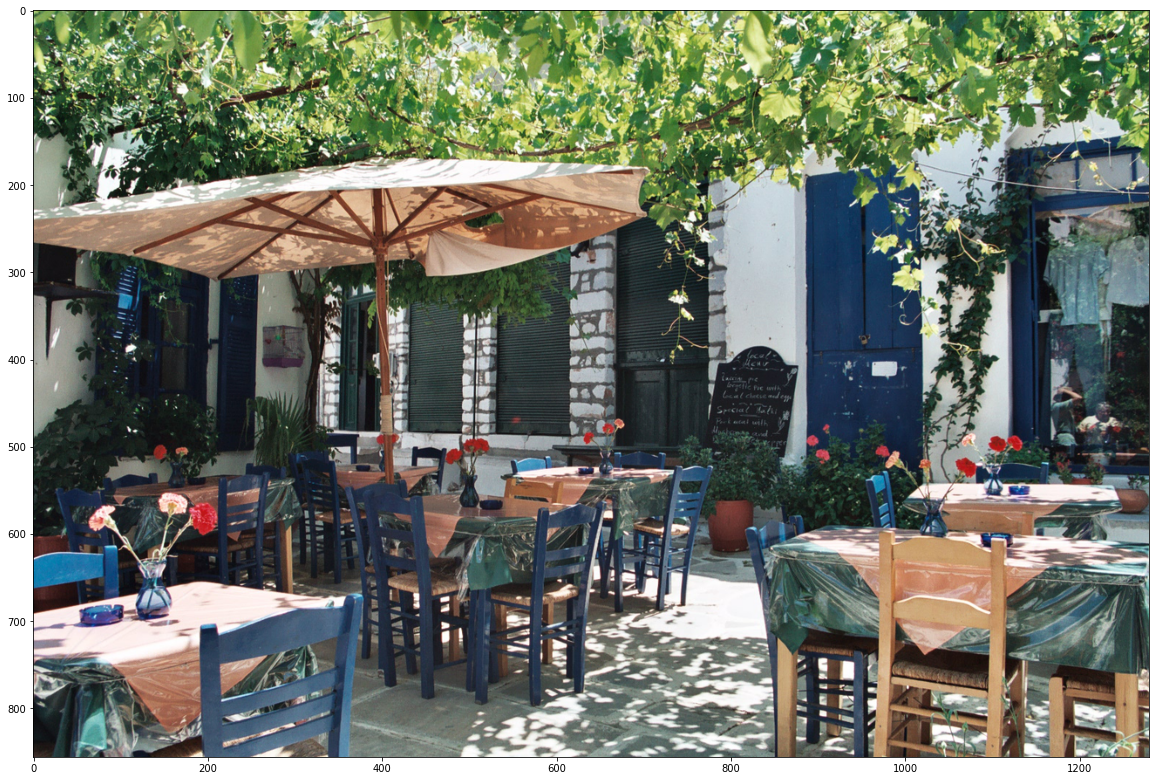

In [4]:
# By Heiko Gorski, Source: https://commons.wikimedia.org/wiki/File:Naxos_Taverna.jpg
image_url = "https://upload.wikimedia.org/wikipedia/commons/6/60/Naxos_Taverna.jpg" 
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)

In [18]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [6]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [26]:
def run_detector(detector, path):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  print(result)
  result = {key:value.numpy() for key,value in result.items()}
  print(result)
  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

  display_image(image_with_boxes)

{'detection_class_entities': <tf.Tensor: shape=(100,), dtype=string, numpy=
array([b'Chair', b'Table', b'Table', b'Chair', b'Tree', b'Table',
       b'Chair', b'Chair', b'Chair', b'Chair', b'Tree', b'Flowerpot',
       b'Table', b'Houseplant', b'Kitchen & dining room table', b'Table',
       b'Chair', b'Umbrella', b'Table', b'Kitchen & dining room table',
       b'Table', b'Chair', b'Chair', b'Chair', b'Table', b'Chair',
       b'Table', b'Table', b'Houseplant', b'Chair', b'Tree', b'Plant',
       b'Chair', b'Building', b'House', b'Tent', b'Plant', b'Chair',
       b'Building', b'Table', b'Chair', b'Tree', b'Chair', b'Furniture',
       b'Chair', b'Chair', b'Chair', b'House', b'Table', b'Plant',
       b'Chair', b'Plant', b'Chair', b'Tree',
       b'Kitchen & dining room table', b'Flower',
       b'Kitchen & dining room table', b'Table', b'Chair', b'Houseplant',
       b'Chair', b'Table', b'Houseplant', b'Table', b'Tree', b'Chair',
       b'Coffee table', b'Chair', b'Kitchen & dining r

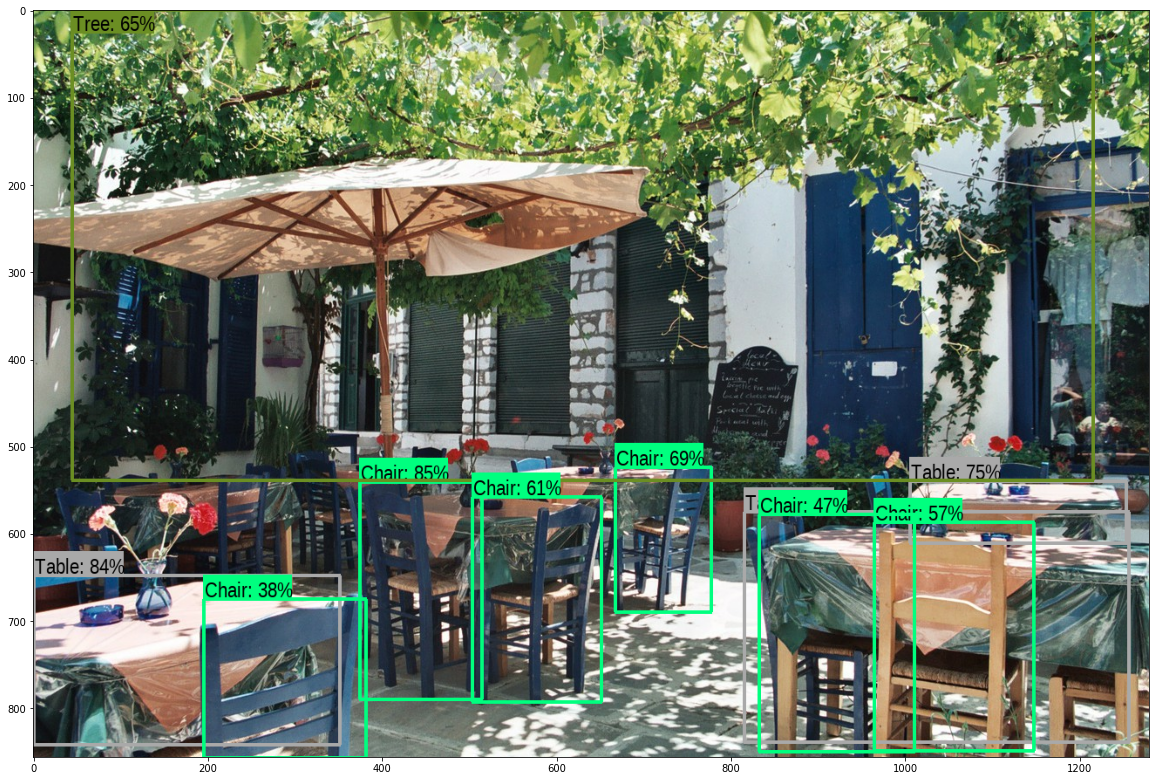

In [20]:
run_detector(detector, downloaded_image_path)

In [28]:
image_urls = [
  # Source: https://commons.wikimedia.org/wiki/File:The_Coleoptera_of_the_British_islands_(Plate_125)_(8592917784).jpg
  "https://upload.wikimedia.org/wikipedia/commons/1/1b/The_Coleoptera_of_the_British_islands_%28Plate_125%29_%288592917784%29.jpg",
  # By Américo Toledano, Source: https://commons.wikimedia.org/wiki/File:Biblioteca_Maim%C3%B3nides,_Campus_Universitario_de_Rabanales_007.jpg
  "https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg/1024px-Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg",
  # Source: https://commons.wikimedia.org/wiki/File:The_smaller_British_birds_(8053836633).jpg
  "https://upload.wikimedia.org/wikipedia/commons/0/09/The_smaller_British_birds_%288053836633%29.jpg",
  "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSh-XinzsiIEdkgQTIm8jFYhDvPfn-xvqY0PA&usqp=CAU",
  "https://aihub.or.kr/sites/default/files/inline-images/105.%E1%84%80%E1%85%A9%E1%86%BC%E1%84%89%E1%85%A1%28%E1%84%83%E1%85%A2%E1%84%91%E1%85%AD%E1%84%83%E1%85%A9%E1%84%86%E1%85%A7%E1%86%AB%E1%84%8B%E1%85%B5%E1%84%86%E1%85%B5%E1%84%8C%E1%85%B5%29.jpg"
  ]

def detect_img(image_url):
  start_time = time.time()
  image_path = download_and_resize_image(image_url, 640, 480)
  run_detector(detector, image_path)
  end_time = time.time()
  print("Inference time:",end_time-start_time)

Image downloaded to /tmp/tmpjkvxwrwa.jpg.
{'detection_class_entities': <tf.Tensor: shape=(100,), dtype=string, numpy=
array([b'Helmet', b'Helmet', b'Clothing', b'Man', b'Clothing', b'Man',
       b'Person', b'Person', b'Human arm', b'Camera', b'Man',
       b'Human arm', b'Human face', b'Human head', b'Human arm',
       b'Person', b'Human head', b'Sports uniform', b'Clothing',
       b'Human arm', b'Shirt', b'Human face', b'Human hand', b'Vehicle',
       b'Human body', b'Human body', b'Human face', b'Mobile phone',
       b'Mammal', b'Land vehicle', b'Football helmet', b'Suit', b'Dress',
       b'Helmet', b'Human arm', b'Boy', b'Jacket', b'Mammal',
       b'Human hand', b'Suit', b'Human arm', b'Man', b'Human face',
       b'Clothing', b'Human arm', b'Window', b'Person', b'Woman',
       b'Fashion accessory', b'Human head', b'Sports uniform',
       b'Human hand', b'Human face', b'Human hair', b'Human face',
       b'Human face', b'Mammal', b'Toy', b'Human arm', b'Television',
       

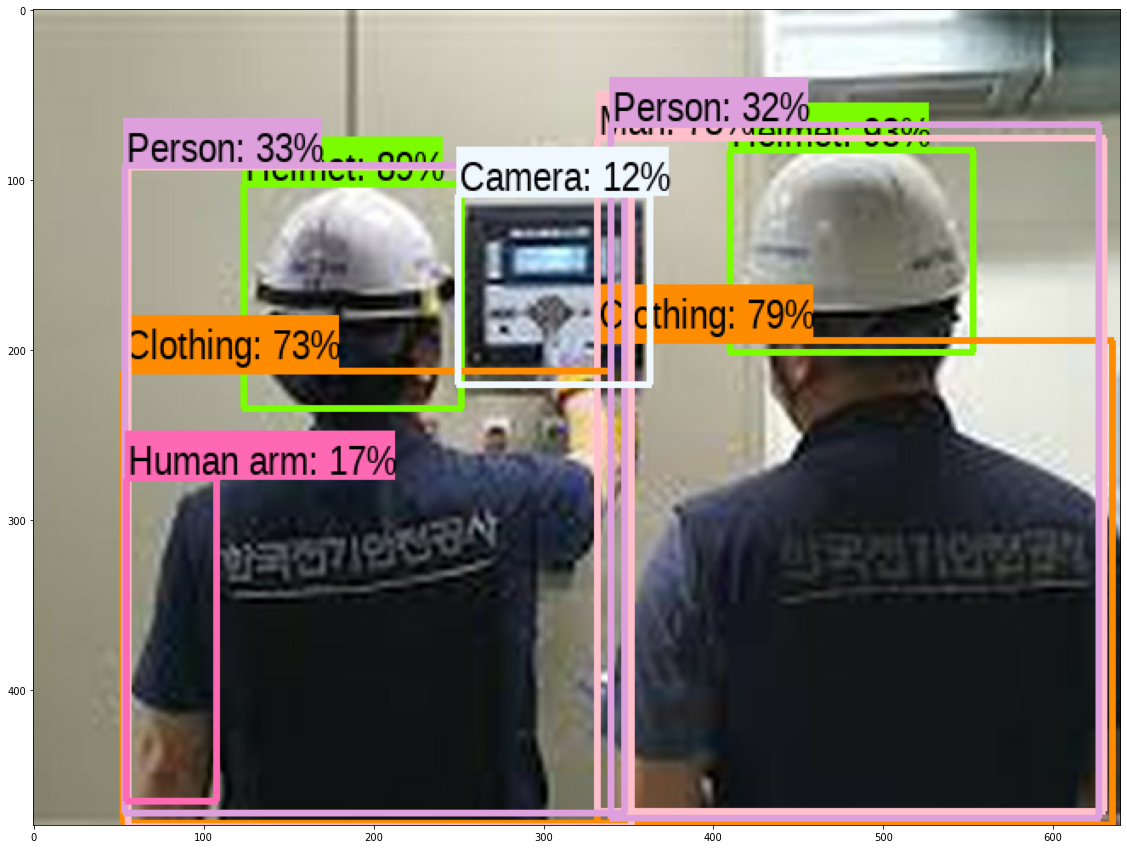

In [21]:
detect_img(image_urls[3])

Image downloaded to /tmp/tmpkf2j8xhd.jpg.
{'detection_class_entities': <tf.Tensor: shape=(100,), dtype=string, numpy=
array([b'Helmet', b'Helmet', b'Footwear', b'Person', b'Person', b'Person',
       b'Man', b'Man', b'Clothing', b'Man', b'Footwear', b'Footwear',
       b'Clothing', b'Man', b'Clothing', b'Clothing', b'Man', b'Footwear',
       b'Person', b'Footwear', b'Footwear', b'Footwear', b'Clothing',
       b'Human face', b'Trousers', b'Footwear', b'Person', b'Jeans',
       b'Hiking equipment', b'Football helmet', b'Mammal', b'Footwear',
       b'Sports equipment', b'Human leg', b'Wheel', b'Footwear',
       b'Hiking equipment', b'Human head', b'Footwear', b'Footwear',
       b'Clothing', b'Footwear', b'Mammal', b'Human leg', b'Footwear',
       b'Mammal', b'Mammal', b'Footwear', b'Human head', b'Mammal',
       b'Man', b'Sports equipment', b'Human face', b'Sports equipment',
       b'Human head', b'Tire', b'Helmet', b'Helmet', b'Clothing',
       b'Clothing', b'Human face', b'Hik

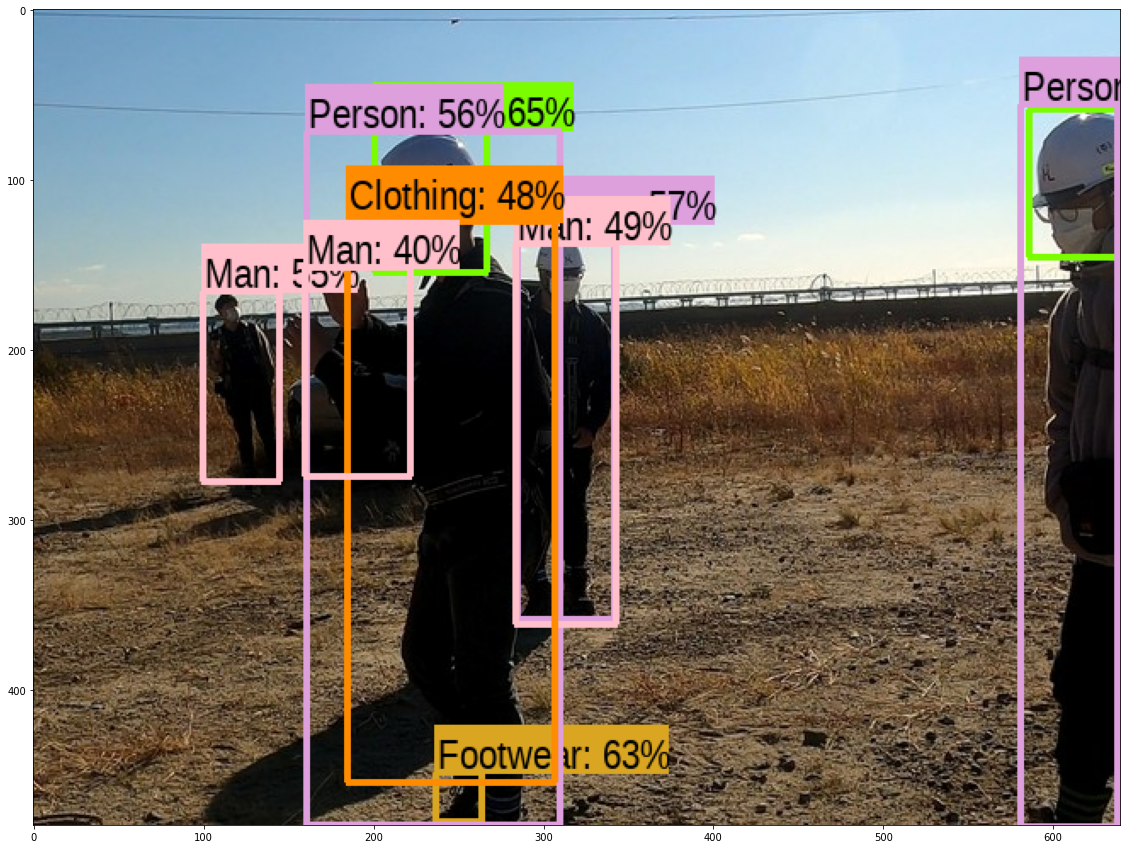

In [30]:
detect_img(image_urls[4])